/tmp/ipykernel_311824/2713918730.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


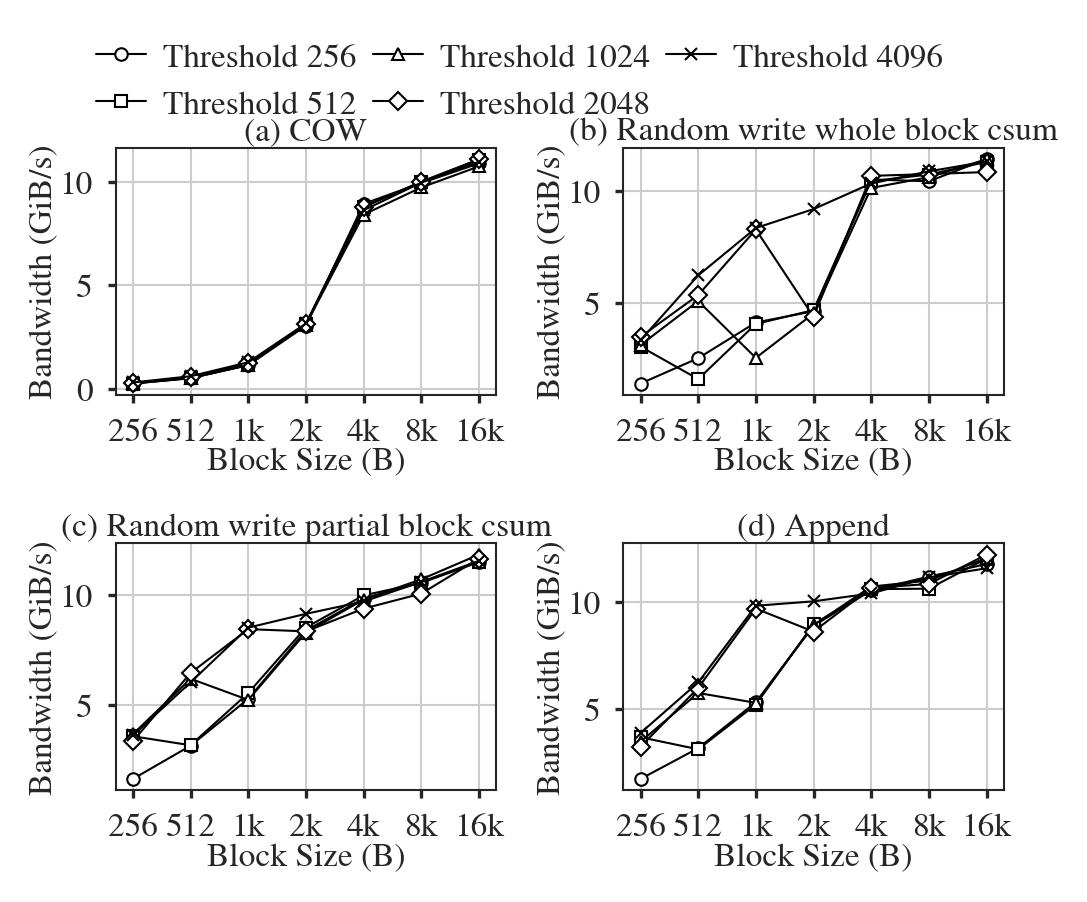

In [2]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

# Paper specific settings
STANDARD_WIDTH = 17.8  # cm
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH

# Convert cm to inch for figure sizing
def cm_to_inch(value):
    return value / 2.54

# Matplotlib and style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-v0_8-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.size"] = 8
pd.options.display.max_columns = None
pd.options.display.max_rows = None

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(7)))

# Read performance data
df = pd.read_csv(
    "./performance-comparison-table-store", delim_whitespace=True,
    names=['fs', 'ops', 'filesz', 'blksz', 'numjobs', 'bandwidth(MiB/s)'],
    skiprows=1
)

# Extract components
# threshold = last part of fs (e.g., 'parfs-12-256' -> 256)
# prefix = fs string without the last two segments (e.g., 'parfs-12-256' -> 'parfs')
df['parts'] = df['fs'].str.split('-')
df['threshold'] = df['parts'].str[-1].astype(int)
df['prefix'] = df['parts'].str[:-2].str.join('-')
# Convert bandwidth to GiB/s
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024

# Compute mean bandwidth for each prefix, threshold, operation, block size
df_avg = (
    df.groupby(['prefix', 'threshold', 'ops', 'blksz'])['bandwidth']
      .mean()
      .reset_index()
)

line_width = 0.5
marks = ['o', 's', '^', 'D', 'x', '>', '<', 'p', '*', 'h', 'v', '1', '2', '3', '4']

# Plot configurations: (prefix, operation, title)
configs = [
    {"prefix": "parfs", "op": "randwrite", "title": "(a) COW"},
    {"prefix": "append_csum_whole_block", "op": "write", "title": "(b) Random write whole block csum"},
    {"prefix": "append_csum_partial_block", "op": "write", "title": "(c) Random write partial block csum"},
    {"prefix": "append_no_csum", "op": "write", "title": "(d) Append"}
]

handles = []
labels = []
for i, cfg in enumerate(configs):
    ax = plt.subplot(2, 2, i + 1)
    # Filter data for this panel
    df_cfg = df_avg[(df_avg['prefix'] == cfg['prefix']) & (df_avg['ops'] == cfg['op'])]
    thresholds = sorted(df_cfg['threshold'].unique())
    for idx, th in enumerate(thresholds):
        df_th = df_cfg[df_cfg['threshold'] == th].sort_values('blksz')
        marker = marks[idx % len(marks)]
        # Only label in first subplot for legend\        label = f'Thr={th}' if i == 0 else None
        line, = ax.plot(
            df_th['blksz'], df_th['bandwidth'],
            color='black', marker=marker,
            markerfacecolor='white', markeredgecolor='black',
            markersize=3, markeredgewidth=0.5,
            linewidth=line_width
        )
        if i == 0:
            handles.append(line)
            labels.append(f'Threshold {th}')
    # Axis settings
    ax.set_xscale('log')
    ax.set_xticks([256, 512, 1024, 2048, 4096, 8192, 16384])
    ax.set_xticklabels(['256', '512', '1k', '2k', '4k', '8k', '16k'])
    ax.set_xlabel("Block Size (B)", labelpad=0)
    ax.set_ylabel("Bandwidth (GiB/s)", labelpad=0)
    ax.set_title(cfg['title'], fontsize=8, pad=2)
    ax.tick_params(axis='both', which='major', length=2, direction='out')
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

# Global legend
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1), ncol=3, columnspacing=0.5, handletextpad=0.5, handlelength=1.5, frameon=False)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.34, wspace=0.07)
plt.tight_layout()
plt.savefig("./FIO-IO-THRESHOLD.pdf", bbox_inches='tight', pad_inches=0.05)
